# Intro to linear inversion in R

[Read how to get R installed in a conda environment.](https://www.continuum.io/blog/developer/jupyter-and-conda-r)

## Make the model

First we make a cartoon earth model, using products of Vp and Rho to make impedance.

In [62]:
# Impedance, imp:                           Vp    rho
imp <- matrix(rep(1, len=51), nrow = 51) * 2550 * 2650
imp[c(10:15),] <-                          2700 * 2750
imp[c(15:27),] <-                          2400 * 2450
imp[c(27:35),] <-                          2800 * 3000

Now we compute the reflection coefficients with the same shifting trick we use in Python. I've put the Python equivalents here to try to make the R notation a little clearer.

In [2]:
# Python:   imp[1:]        imp[:-1]           imp[1:]         imp[:-1]
m <- (tail(imp, -1) - head(imp, -1)) /  (tail(imp, -1) + head(imp, -1))

## Make `G`

Now we need a function with which to generate a Ricker wavelet. I found this one on the Internet:

In [63]:
genrick <- function(duration, dt, f) {
    # RICKER WAVELET GENERATOR
    # Written by Leonard Lisapaly (leonardl@fisika.ui.ac.id)
    # Converted to R by J Lees, 2004
    #
    # INPUTS
    # freq = wavelet dominant frequency [Hz]
    # dt   = sampling interval [sec]
    # nw   = duration of wavelet [sec]
    nw <- duration / dt
    a  <- f * sqrt(pi) / 2
    nc <- (nw + 1) / 2
    tc <- (nc - 1) * dt
    t  <- seq(from=0, length=nw-1) * dt
    b  <- pi * f * (t - tc)
    w  <- a * (1 - 2*b^2) * exp(-b^2)
    return(w)
}

We use the function to make a wavelet 100 points long:

In [47]:
wavelet <- genrick(0.101, 0.001, 100)

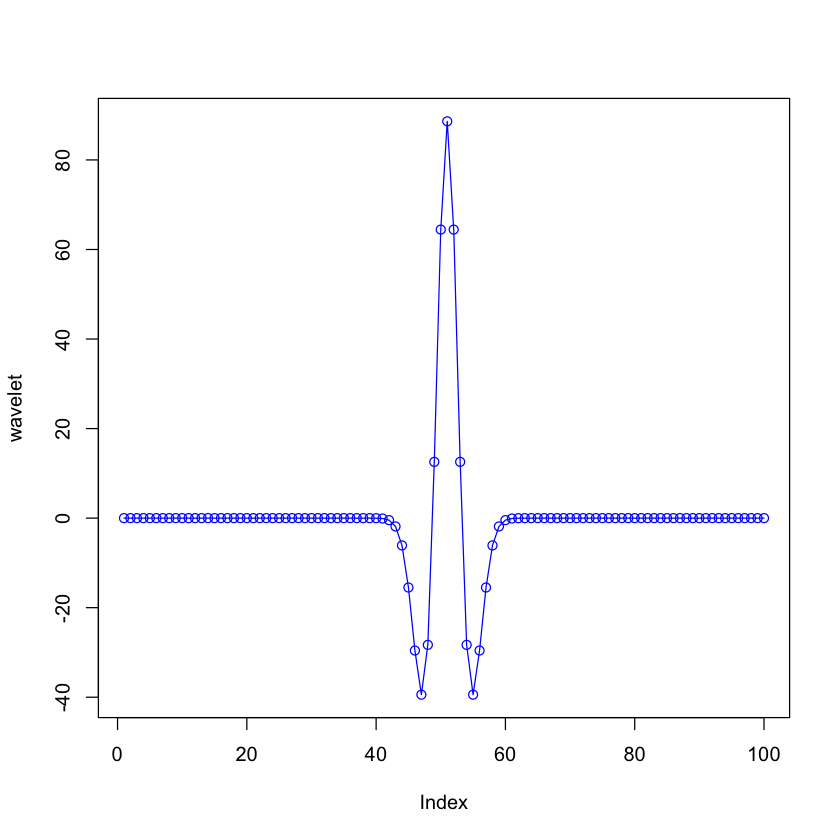

In [48]:
plot(wavelet, type='o', col='blue')

Because of how the `toeplitz()` function in R works, we actually only want half of the wavelet, so we take its second half. (Aside: slicing in R is not as convenient as it is in Python!)

In [49]:
w_ <- wavelet[((1 + length(wavelet)/2):length(wavelet))]

Now make the Toeplitz matrix, essentially the convolution matrix of the wavelet, and select only every other row to end up with an underdetermined problem.

In [50]:
G <- toeplitz(w_)[c(TRUE, FALSE),]

## Forward model the data

Now we can do

$$ \mathbf{d} = \mathbf{G} \mathbf{m} $$

In [51]:
d <- G %*% m

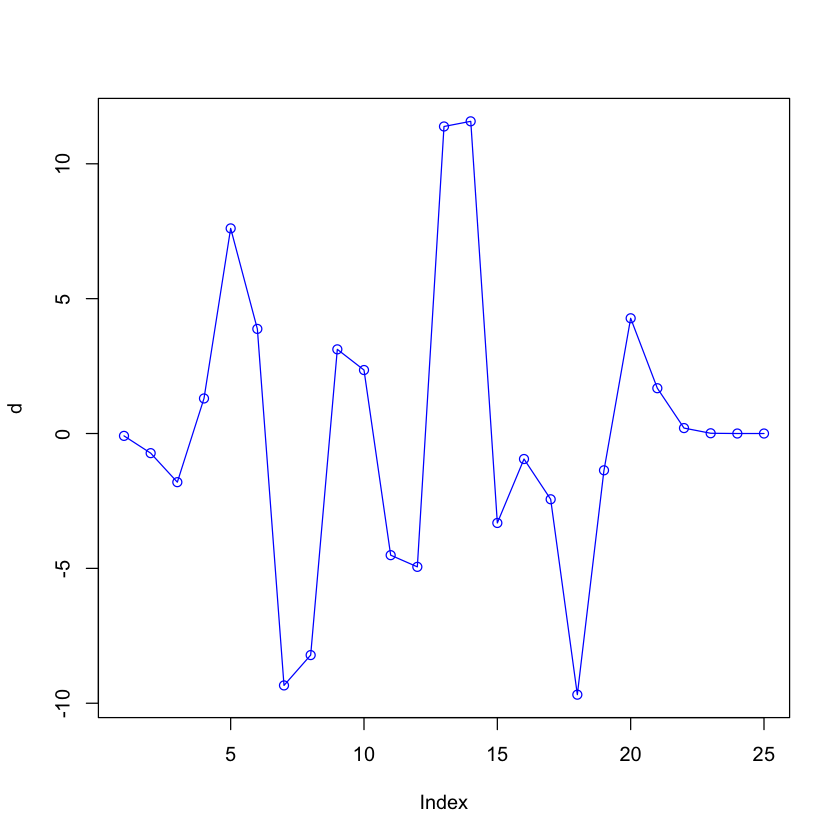

In [52]:
plot(d, type='o', col='blue')

## Minimum norm

Rmember that our system is underdetermined: the matrix **G** is 'fat' (more columns than rows). So we can compute the minimum norm solution via the right inverse:

$$ \mathbf{\hat{m}} = \mathbf{G}^\mathrm{T} ( \mathbf{G}  \mathbf{G}^\mathrm{T} )^{-1} \mathbf{d} $$

In [53]:
m_est <- t(G) %*% solve(G %*% t(G)) %*% d

In [54]:
d_pred <- G %*% m_est

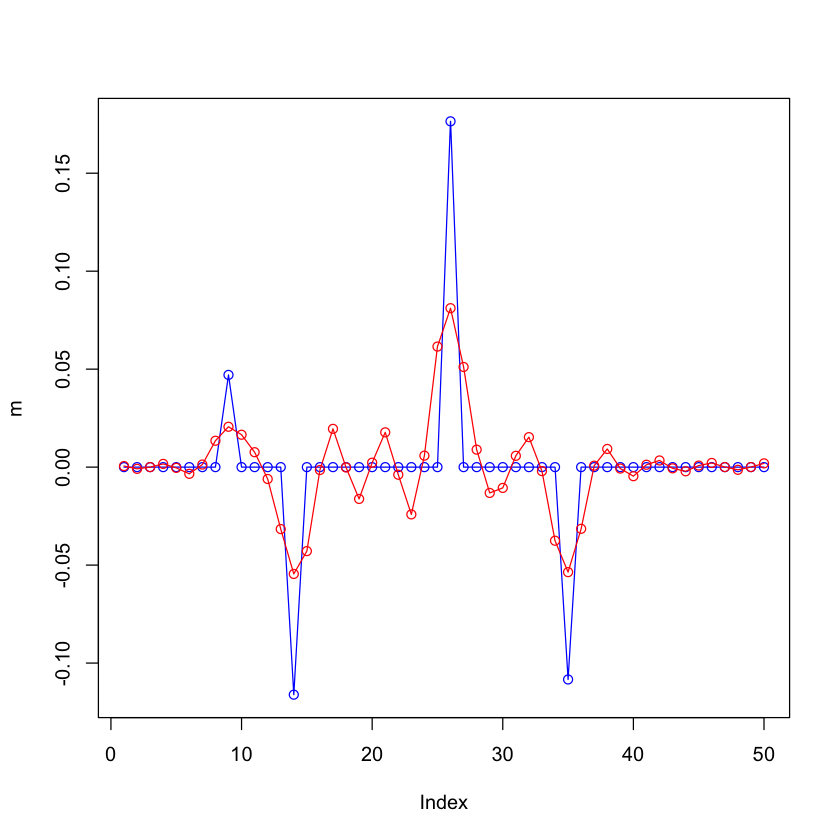

In [57]:
plot(m, type='o', col='blue')
lines(m_est, type='o', col='red')

#### Original model norm

In [58]:
t(m) %*% m

0.05858362


#### New model norm

In [59]:
t(m_est) %*% m_est

0.02741979


As expected, the predicted data `d_pred` matches the original data `d` perfectly. 

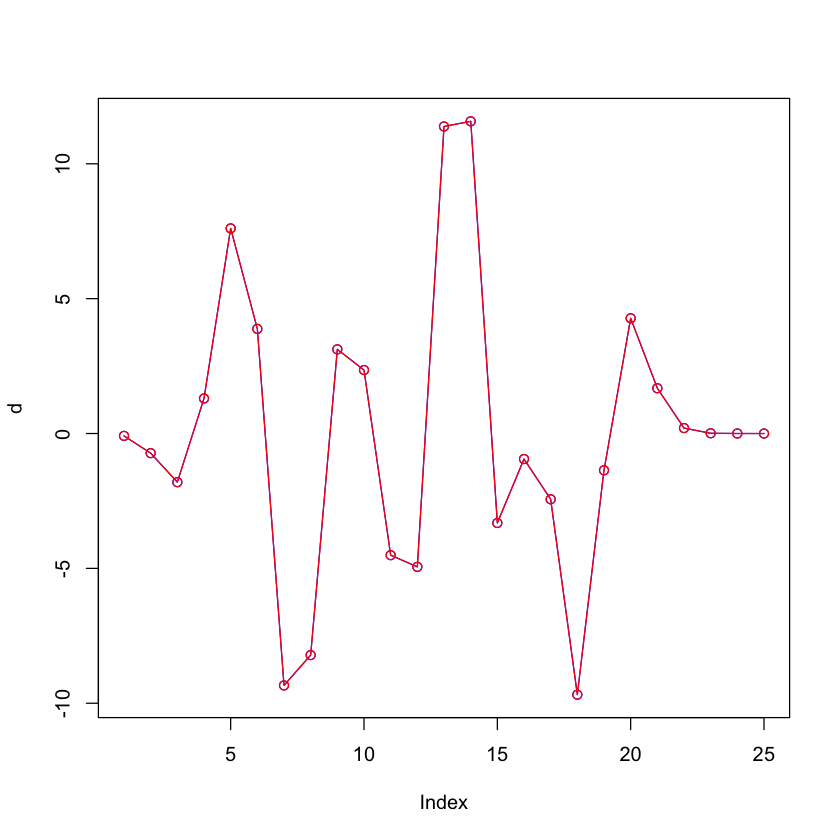

In [61]:
plot(d, type='o', col='blue')
lines(d_pred, type='o', col='red')

## Using R's solver directly... but only if `G` is square

In [ ]:
m_est <- solve(G, d)

## Another example

http://www.r-bloggers.com/dont-invert-that-matrix-why-and-how/